In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import h5py

import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import kvn

colors_ = ["blue", "red", "green", "gray", "black"]

11687
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(10):
    plt.close()

In [3]:
# ------------------------------------------------------------
# --- FUNCTIONS ---
# ------------------------------------------------------------
from scipy.linalg import expm
from scipy.integrate import RK45
mix.reload_module(mix)
mix.reload_module(kvn)

def get_initial_state():
    psi_init = np.zeros(2, dtype = complex)
#     psi_init[0] = np.sqrt(0.4)
#     psi_init[1] = np.sqrt(0.6)
    
    psi_init[0] = np.sqrt(0.0)
    psi_init[1] = np.sqrt(1.0)
    return psi_init
    

def case_Hermitian():
    print("--- Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


def case_non_Hermitian():
    print("--- NON-Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1 - 0.4j
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1 - 0.4j
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


# input: Hi = i*H:
def ref_computation(Hi, psi_init):
    def calc_y(t,y):
        y = -Hi.dot(y) 
        return y
    
    psi_out = np.zeros((Nt_,2), dtype=complex)
    psi_out[0,0] = psi_init[0]
    psi_out[0,1] = psi_init[1]
    
    oo = RK45(calc_y, t_[0], psi_out[0,:], t_[-1], first_step=dt_, max_step=dt_)
    Nt_act = 0
    oo.step() # skip one time step
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        psi_out[Nt_act,:] = oo.y
    print()
    print("--- refence computation ---")
    print("sum psi[RK-max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_out[Nt_act,:])**2)))
    return psi_out


def compare_plots(psi_ref, psi_LCHS, id_var):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # --- REAL PART ---
    ax.plot(t_,      psi_ref.real[:,id_var],  "-b", linewidth = 2, label="Re: ref")
    ax.plot(t_,      psi_ref.imag[:,id_var],  "-r", linewidth = 2, label="Im: ref")
    ax.plot(t_plot_, psi_LCHS.real[:,id_var], 
        "b", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="Re: LCHS"
    )
    ax.plot(t_plot_, psi_LCHS.imag[:,id_var], 
        "r", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="Im: LCHS"
    )
    plt.xlabel('$t$')
    plt.ylabel("Re: " + "var[{:d}]".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()
    return


def plot_one_sim(t, psi):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    ax.plot(t, psi.real[:,0], "-b", linewidth = 2, label="Re var1")
    ax.plot(t, psi.real[:,1], "-r", linewidth = 2, label="Re var2")

    # ax.plot(t, psi.imag[:,0], "--b", linewidth = 2, label="Im var1")
    # ax.plot(t, psi.imag[:,1], "--r", linewidth = 2, label="Im var2")

    ax.plot(t, psi.imag[:,0], "--", color = "gray", linewidth = 2, label="Im var1")
    ax.plot(t, psi.imag[:,1], "--", color = "green", linewidth = 2, label="Im var2")

    plt.xlabel('$t$')
    plt.ylabel("psi")
    ax.legend()
    plt.grid(True)
    plt.show()
    return

--- NON-Hermitian Hamiltonian ---

*** Original Hamiltonian (without mult. by i)***
--- 0 ---
 1.000-0.400j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000-0.400j

--- refence computation ---
sum psi[RK-max-time]**2: 4.076e-02


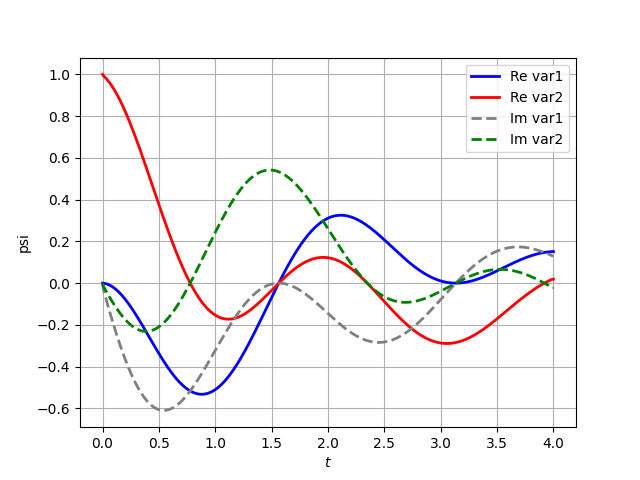

In [4]:
# ---------------------------------------------------
# --- Grid's parameters ---
# ---------------------------------------------------
mix.reload_module(kvn)

# --- Choose Hermitian or non-Hermitian ---
flag_Hermitian_      = False

# --- perform or not trotterization in pyton-LCHS ---
flag_trotterization_ = True

# --- Choose how the weights are computed in QuCF simulations ---

sel_case_weights_ = 1  # Hermitian with qsrt(weights)
# sel_case_weights_ = 2  # Hermitian with weights (without t compression gadget)

if flag_Hermitian_:
    if sel_case_weights_ == 1:
        path_qucf_ = "../QuCF/tests/LCHS-Hermitian-simple/"
        coef_sign_ = 1
    if sel_case_weights_ == 2:
        path_qucf_ = "../QuCF/tests/LCHS-Hermitian-simple-OPT2/"
        coef_sign_ = -1
else:
    if sel_case_weights_ == 1:
        path_qucf_ = "../QuCF/tests/LCHS-non-Hermitian-simple/"
        coef_sign_ = 1
    if sel_case_weights_ == 2:
        path_qucf_ = "../QuCF/tests/LCHS-non-Hermitian-simple-OPT2/"
        coef_sign_ = -1

nt_          = 9
t_max_       = 4
diff_nt_plot = 6
nk_    = 5
k_max_ = 10

# non-normalized time step to produce the trotterization in the LCHS circuit: 
t_step_ = 0.1

# time grid:
Nt_    = 1 << nt_
t_     = np.linspace(0, t_max_, Nt_)
dt_    = np.diff(t_)[0]

diff_N_ = 1 << diff_nt_plot
N_plot  = 1 << (nt_ - diff_nt_plot)

t_plot_ = np.zeros(N_plot)
for it in range(N_plot):
    t_plot_[it] = it * diff_N_ * dt_
del it

# k-grid for the LCHS:
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# initial state:
psi_init_ = get_initial_state()

# choose the matrix:
if flag_Hermitian_:
    Hi_ = case_Hermitian()
else:
    Hi_ = case_non_Hermitian()

# reference computation:
psi_ref_ = ref_computation(Hi_, psi_init_)
plot_one_sim(t_, psi_ref_)

In [5]:
# --------------------------------------------
# --- LCHS computation (in python) ---
# --------------------------------------------
mix.reload_module(kvn)

# LCHS computation:
if flag_trotterization_:
    print("Performing LCHS computation (with trotterization)...")
else:
    print("Performing LCHS computation (without trotterization)...")

psi_LCHS = np.zeros((N_plot, 2), dtype = complex)
for it in range(N_plot):
    id_t = it * diff_N_  
    psi_LCHS[it,:] = kvn.LCHS_computation(
        k_, dt_,
        Hi_, psi_init_, id_t, 
        flag_trotterization_, 
        flag_print = False
    )
del id_t, it
print("Done.")

Performing LCHS computation (with trotterization)...
Done.


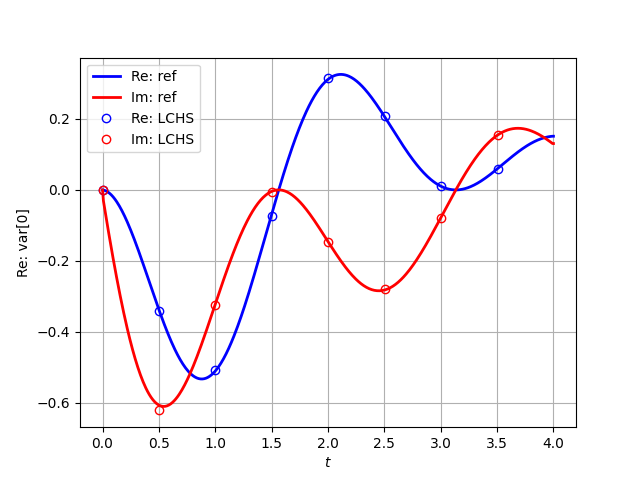

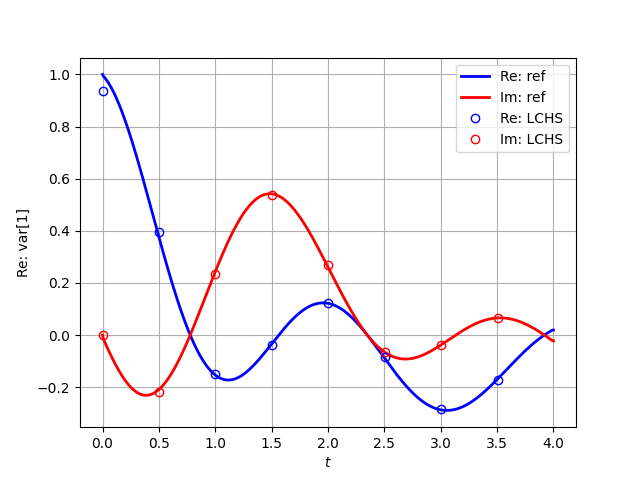

max. abs. err: 6.361e-02


In [6]:
# ----------------------------------------------------------
# --- Plot LCHS results (from python simulations) ---
# ----------------------------------------------------------
compare_plots(psi_ref_, psi_LCHS, id_var = 0)
compare_plots(psi_ref_, psi_LCHS, id_var = 1)

max_abs_err = 0
for it in range(len(t_plot_)):
    err = np.max(np.abs(psi_ref_[it * diff_N_] - psi_LCHS[it]))
    if max_abs_err < err:
        max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))
del max_abs_err, err , it

In [7]:
# ---------------------------------------------------------------------------------------
# --- Parameters for the block encoding ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)


def find_nonsparsity(A):
    # Assume that A is a square matrix.
    coef_zero = 1e-12
    N = A.shape[0]
    final_nonsparsity = 0
    for ir in range(N):
        nonsparsity_row = 0
        for ic in range(N):
            if np.abs(A[ir, ic]) > coef_zero:
                nonsparsity_row += 1
        if nonsparsity_row > final_nonsparsity:
            final_nonsparsity = nonsparsity_row
    return final_nonsparsity


def find_norm_of_matrix(A):
    N = A.shape[0]
    rows_sum = np.zeros(N)
    for ir in range(N):
        rows_sum[ir] = np.sqrt(np.sum(np.abs(A[ir,:])**2))
    coef_norm = np.max(rows_sum)
    return coef_norm
    
            
def compute_normalized_matrix(A, name_A):
    nonsparsity = find_nonsparsity(A)
    if nonsparsity == 0:
        return A, 1.0, 0.0
    final_norm = nonsparsity
    
    coef_norm_A = find_norm_of_matrix(A)
    if coef_norm_A > 1:
        final_norm *= coef_norm_A
        
    A_norm = A / final_norm
    
    print()
    print(">>> Matrix {:s}".format(name_A))
    print("nonsparsity, coefnorm: {:d}, {:0.3e}".format(nonsparsity, final_norm))
    
    return A_norm, final_norm, nonsparsity


def compute_angles_2x2(A_norm, nonsparsity, str_A):
    ay_00, az_00 = mix.calc_angles_from_a_value(A_norm[0,0] * nonsparsity)
    ay_01, az_01 = mix.calc_angles_from_a_value(A_norm[0,1] * nonsparsity)
    ay_10, az_10 = mix.calc_angles_from_a_value(A_norm[1,0] * nonsparsity)
    ay_11, az_11 = mix.calc_angles_from_a_value(A_norm[1,1] * nonsparsity)
  
    print("ay_00_{:s}  {:0.12e}".format(str_A, ay_00))
    if az_00 is not None:
        print("az_00_{:s}  {:0.12e}".format(str_A, az_00))

    print("ay_01_{:s}  {:0.12e}".format(str_A, ay_01))
    if az_01 is not None:
        print("az_01_{:s}  {:0.12e}".format(str_A, az_01))

    print("ay_10_{:s}  {:0.12e}".format(str_A, ay_10))
    if az_10 is not None:
        print("az_10_{:s}  {:0.12e}".format(str_A, az_10))

    print("ay_11_{:s}  {:0.12e}".format(str_A, ay_11))
    if az_11 is not None:
        print("az_11_{:s}  {:0.12e}".format(str_A, az_11))
    return

def compute_angles_initialization(psi_init):
    ay_init = 2*np.arccos(psi_init.real[0])
    print("ay_init  {:0.12e}".format(ay_init))
    return
# --------------------------------------------------------------------------------------------    
    
# --- Find Hermitian and anti-Hermitian parts of the system ---
Ah, Aa = mix.get_herm_aherm_parts(Hi_)

print("\n*** Hermitian part of i*H (Ah) ***")
mix.print_matrix(Ah)

print("\n*** Anti-Hermitian part of i*H (Aa) ***")
mix.print_matrix(Aa)

Ba     = Aa 
B_kmax = - k_max_ * Ah
Bk     =      dk_ * Ah

# --- Normalize the hermitian and anti-Hermitian parts of the matrix ---
Ba_norm,     ncoef_a,    nonsparsity_a    = compute_normalized_matrix(Ba, "Ba")
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = compute_normalized_matrix(B_kmax, "B_kmax")
Bk_norm,     ncoef_k,    nonsparsity_k    = compute_normalized_matrix(Bk, "Bk")

print("\n*** Normalized Aa ***")
mix.print_matrix(Ba_norm, ff=[25, 3, "e"])

print("\n*** Normalized ( - kmax*Ah) ***")
mix.print_matrix(B_kmax_norm, ff=[25, 3, "e"])

print("\n*** Normalized dk*Ah ***")
mix.print_matrix(Bk_norm, ff=[25, 3, "e"])

# Print initial state:
print("\n*** Initial state ***")
mix.print_array(psi_init_, ff=[25, 3, "e"])

# --- The number of qubits for encoding variables ---
print("\n\n//--- For data ---")
print("nx \t{:d}".format(1))

# --- Compute angles for the herm. and a-herm. matrices ---
print("\n//--- The angles for the BE oracles ---")
if nonsparsity_a > 0:
    compute_angles_2x2(Ba_norm,     nonsparsity_a,    "a")
if nonsparsity_kmax > 0:
    compute_angles_2x2(B_kmax_norm, nonsparsity_kmax, "kmax")
if nonsparsity_k > 0:
    compute_angles_2x2(Bk_norm,     nonsparsity_k,    "k")

# --- Compute angles for the initialization circuit ---
print("\n//--- The angles for the initialization ---")
compute_angles_initialization(psi_init_)

# --- Compute angles for the weights ---
print("\n--- Angles for the weight-oracle are computed in calc-weights !!!---")

# --- Time steps ---
if flag_Hermitian_:
    dt_a    = ncoef_a    * t_step_
    print("\n--- Time steps ---")
    print("dt_a:    {:0.6e}".format(dt_a))
else:
    dt_a    = ncoef_a    * t_step_ / 2.
    dt_kmax = ncoef_kmax * t_step_
    dt_k    = ncoef_k    * t_step_
    print("\n--- Time steps ---")
    print("dt_a:    {:0.6e}".format(dt_a))
    print("dt_kmax: {:0.6e}".format(dt_kmax))
    print("dt_k:    {:0.6e}".format(dt_k))


*** Hermitian part of i*H (Ah) ***
--- 0 ---
 0.400+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j  0.400+0.000j

*** Anti-Hermitian part of i*H (Aa) ***
--- 0 ---
 1.000+0.000j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j

>>> Matrix Ba
nonsparsity, coefnorm: 2, 4.472e+00

>>> Matrix B_kmax
nonsparsity, coefnorm: 1, 4.000e+00

>>> Matrix Bk
nonsparsity, coefnorm: 1, 1.000e+00

*** Normalized Aa ***
--- 0 ---
     2.236e-01+0.000e+00j      4.472e-01+0.000e+00j
--- 1 ---
     4.472e-01+0.000e+00j      2.236e-01+0.000e+00j

*** Normalized ( - kmax*Ah) ***
--- 0 ---
    -1.000e+00+0.000e+00j      0.000e+00+0.000e+00j
--- 1 ---
     0.000e+00+0.000e+00j     -1.000e+00+0.000e+00j

*** Normalized dk*Ah ***
--- 0 ---
     2.581e-01+0.000e+00j      0.000e+00+0.000e+00j
--- 1 ---
     0.000e+00+0.000e+00j      2.581e-01+0.000e+00j

*** Initial state ***
     0.000e+00+0.000e+00j      1.000e+00+0.000e+00j 


//--- For data ---
nx 	1

//--- The angles for the BE oracles ---
ay_00_a  2.21429


--- refence computation ---
sum psi[RK-max-time]**2: 1.000e+00


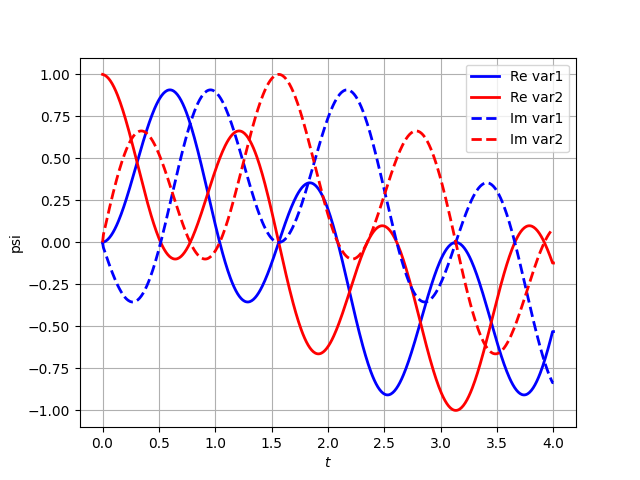

In [22]:
# # ----------------------------------------------------------------------------------------
# # --- For non-Hermitian: intermediate simulation (only as a TEST without the selector) ---
# # ----------------------------------------------------------------------------------------
# def ref_computation_inter(A, psi_init):
#     def calc_y(t,y):
#         y = -iA.dot(y) 
#         return y
    
#     iA = 1j * A
    
#     psi_out = np.zeros((Nt_,2), dtype=complex)
#     psi_out[0,0] = psi_init[0]
#     psi_out[0,1] = psi_init[1]
    
#     oo = RK45(calc_y, t_[0], psi_out[0,:], t_[-1], first_step=dt_, max_step=dt_)
#     Nt_act = 0
#     oo.step() # skip one time step
#     while mix.compare_two_strings(oo.status, "running"):
#         oo.step()
#         Nt_act += 1
#         psi_out[Nt_act,:] = oo.y
#     print()
#     print("--- refence computation ---")
#     print("sum psi[RK-max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_out[Nt_act,:])**2)))
#     return psi_out
# # -----------------------------------------------------------
# psi_ref_ = ref_computation_inter(Ba + B_kmax, psi_init_)
# plot_one_sim(t_, psi_ref_)

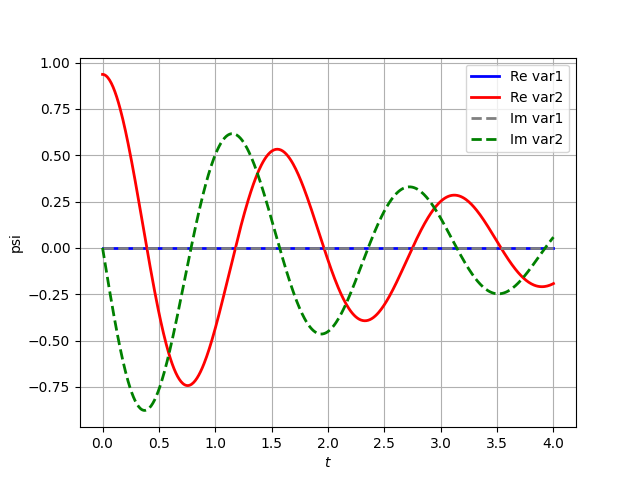

In [8]:
# # ------------------------------------------------------------------------------------------
# # --- For non-Hermitian: intermediate simulation (only as a TEST just WITH the selector) ---
# # ------------------------------------------------------------------------------------------
# mix.reload_module(kvn)

# psi_ref_ = np.zeros((Nt_, 2), dtype = complex)
# for it in range(Nt_): 
#     psi_ref_[it,:] = kvn.LCHS_computation_FAKE(k_, dt_,Hi_, psi_init_, it)
# del it
# plot_one_sim(t_, psi_ref_)


--------------------------------------------------
--- t = 5.000 ---
--------------------------------------------------

Reading the file ../QuCF/tests/LCHS-non-Hermitian-simple//N_5_OUTPUT.hdf5...
Name of the simulation is N_5
Simulation has been performed  03-20-2024 16:31:09
success prob: 9.766e-04

--- QSP: qsp_a ---
dt: 0.224
nt: 1.000

--- QSP: qsp_k ---
dt: 0.100
nt: 1.000

--- QSP: qsp_kmax ---
dt: 0.400
nt: 1.000
nk: 5

--------------------------------------------------
--- t = 10.000 ---
--------------------------------------------------

Reading the file ../QuCF/tests/LCHS-non-Hermitian-simple//N_10_OUTPUT.hdf5...
Name of the simulation is N_10
Simulation has been performed  03-20-2024 16:31:41
success prob: 9.766e-04

--- QSP: qsp_a ---
dt: 0.224
nt: 1.000

--- QSP: qsp_k ---
dt: 0.100
nt: 1.000

--- QSP: qsp_kmax ---
dt: 0.400
nt: 1.000
nk: 5

--------------------------------------------------
--- t = 15.000 ---
--------------------------------------------------

Reading 

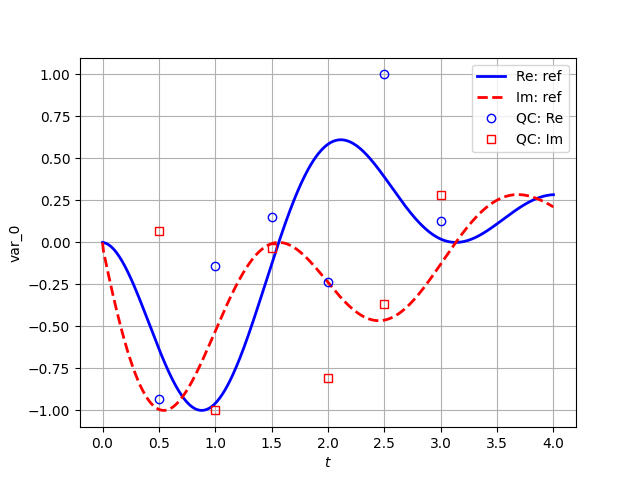

max. abs. err: 1.883e+00


In [9]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
import h5py
mix.reload_module(mse)

# -------------------------------------------------
def read_time_step(fname):
    print("Reading the file: ", fname)
    with h5py.File(fname, "r") as f:
        time_step = f["basic"]["par"][()]
    return time_step


def plot_QC_vs_REF(t_ref, psi_ref, qt_points, psi_qc_points, id_var):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # --- normalization of the REF signal ---
    coef_real = np.max(np.abs(psi_ref.real[:,id_var]))
    if coef_real < 1e-16:
        coef_real = 1.0
    coef_imag = np.max(np.abs(psi_ref.imag[:,id_var]))
    if coef_imag < 1e-16:
        coef_imag = 1.0
    psi_ref.real[:,id_var] = np.array(psi_ref.real[:,id_var] / coef_real)
    psi_ref.imag[:,id_var] = np.array(psi_ref.imag[:,id_var] / coef_imag)

    # --- normalization of the QC signal ---
    coef_real = np.max(np.abs(psi_qc_points.real[:,id_var]))
    if coef_real < 1e-16:
        coef_real = 1.0
    coef_imag = np.max(np.abs(psi_qc_points.imag[:,id_var]))
    if coef_imag < 1e-16:
        coef_imag = 1.0
    psi_qc_points.real[:,id_var] /= coef_real
    psi_qc_points.imag[:,id_var] /= coef_imag
 
    # --- Plotting ---
    ax.plot(t_ref, psi_ref.real[:,id_var], "-b",  linewidth = 2, label="Re: ref")
    ax.plot(t_ref, psi_ref.imag[:,id_var], "--r", linewidth = 2, label="Im: ref")
    
    ax.plot(
        qt_points, coef_sign_ * psi_qc_points.real[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='b', linestyle='None',
        label = "QC: Re"
    )
    ax.plot(
        qt_points, coef_sign_ * psi_qc_points.imag[:,id_var], 
        "s", markerfacecolor='None', markeredgecolor='r', linestyle='None',
        label = "QC: Im"
    )

    plt.xlabel('$t$')
    plt.ylabel("var_{:d}".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()
    return



def read_data(Nt_point):
    print()  
    pro_name_work = "N_{:d}".format(Nt_point)

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.3e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    # qc_state_t *= coef_norm * (dk_c / np.pi)
    qc_state_t *= coef_norm 

    # --- get the time point ---
    Nt = int(om.constants_["Nt"])   
    qt_final = t_step_ * Nt  
    return qt_final, qc_state_t


# ------------------------------------------------
coef_sign_ = -1

Nt_points = [5, 10, 15, 20, 25, 30]
psi_qc    = np.zeros((len(Nt_points), 2), dtype=complex)
qt_points = np.zeros(len(Nt_points))
for ii in range(len(Nt_points)):
    print("\n--------------------------------------------------")
    print("--- t = {:0.3f} ---".format(Nt_points[ii]))
    print("--------------------------------------------------")
    qt_one, psi_one = read_data(Nt_points[ii])
    qt_points[ii] = qt_one
    psi_qc[ii, :] = psi_one  

# --- Plotting ---
plot_QC_vs_REF(t_, psi_ref_, qt_points, psi_qc, id_var = 0)

# --- Compute the error ---
max_abs_err = 0
for id_var in range(2):
    for it in range(len(Nt_points)):
        t1 = qt_points[it]
        v_ref = np.interp(t1, t_, psi_ref_[:, id_var])  
        err = np.max(np.abs(v_ref - psi_qc[it, id_var]))
        if max_abs_err < err:
            max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))

In [ ]:
# --- RESULT: 1/err is linear with k_max --------------------------
# nt = 12
# k_max:              10,        20,        40,       400,
# err(opt-k):  4.926e-02, 2.542e-02, 1.391e-02,
# err(opt-th): 4.926e-02, 2.542e-02, 1.391e-02, 3.434e-03,
# -----------------------------------------------------------------

# LCHS scaling (without trotterization) for a Hermitian matrix [[1, 2] [2, 1]]:
k_max_array =  [   10,    10,    10,    20,    20,   100,   200,  1600,  3200]
nk_array    =  [    4,     5,     7,     7,     8,     9,    10,    13,    14]
mlog_err    = -[1.089, 1.197, 1.198, 1.498, 1.498, 2.196, 2.497, 3.400, 3.701]